In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate
import math
from numpy import mean, std, sqrt
#from pycaret.regression import *
import torch
import torch.nn as nn
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
time_start = datetime.now()

In [2]:
## setting the start and end date
start_date = '2000-01-01'
end_date = datetime.today()

## Data Preprocessing

In [3]:
# Define the currency pair symbol for GBP to BDT
currency_pair = 'GBPBDT=X'
# Fetch exchange rate data from Yahoo Finance
data = yf.download(currency_pair, start=start_date, end=end_date)
# Display the fetched data
print(data)

data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2005-08-11  117.792847  118.646698  117.639801  118.296951  118.296951       0
2005-08-12  118.424652  119.007004  118.366302  118.837151  118.837151       0
2005-08-15  119.118050  119.219200  118.437103  118.508499  118.508499       0
2005-08-16  117.548950  117.955200  117.305496  117.646500  117.646500       0
2005-08-17  117.513199  118.373497  117.383499  118.061096  118.061096       0
...                ...         ...         ...         ...         ...     ...
2024-05-15  144.911179  145.581635  144.911179  144.815948  144.815948       0
2024-05-16  145.669037  146.307632  145.669037  145.581635  145.581635       0
2024-05-17  146.327240  146.327240  145.998520  146.307632  146.307632       0
2024-05-20  146.165665  146.672119  146.165665  146.031754  146.031754       0
2024-05-21  146.848892  146.852859  146.848892  146.

In [4]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,4263,4263.000000,4263.000000,4263.000000,4263.000000,4263.000000,4263.0
mean,2016-03-04 01:59:34.665728512,114.858330,115.065651,114.649703,114.837111,114.837111,0.0
min,2005-08-11 00:00:00,92.207001,92.207001,91.541000,91.512001,91.512001,0.0
25%,2012-02-15 12:00:00,107.449997,107.615288,107.183781,107.435001,107.435001,0.0
50%,2016-03-17 00:00:00,113.930000,114.119904,113.699997,113.878746,113.878746,0.0
75%,2020-04-20 12:00:00,121.970001,122.143650,121.555000,121.845001,121.845001,0.0
max,2024-05-21 00:00:00,146.848892,146.852859,146.848892,146.871231,146.871231,0.0
std,NaN,10.581932,10.578633,10.582297,10.565697,10.565697,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4263 entries, 0 to 4262
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4263 non-null   datetime64[ns]
 1   Open       4263 non-null   float64       
 2   High       4263 non-null   float64       
 3   Low        4263 non-null   float64       
 4   Close      4263 non-null   float64       
 5   Adj Close  4263 non-null   float64       
 6   Volume     4263 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 233.3 KB


## Data Visualization

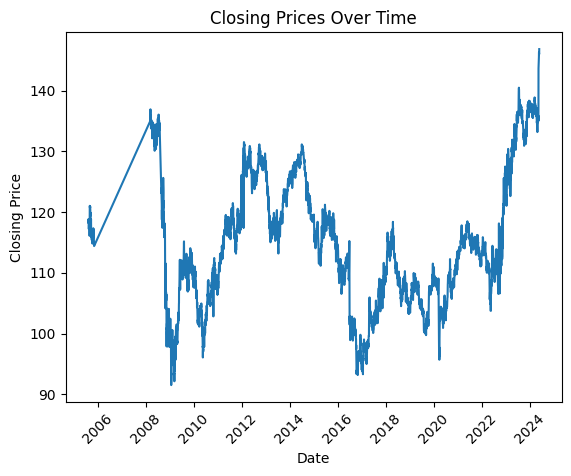

In [6]:
# Plotting the closing prices
plt.plot(data['Date'] ,data['Close'])
plt.title("Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
#plt.xticks([])
plt.xticks(rotation=45)
plt.savefig('GBP to BDT closing price')
plt.show()

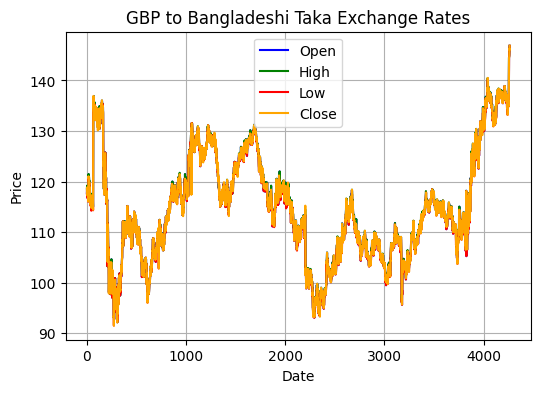

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(data.index, data['Open'], label='Open', color='blue')
plt.plot(data.index, data['High'], label='High', color='green')
plt.plot(data.index, data['Low'], label='Low', color='red')
plt.plot(data.index, data['Close'], label='Close', color='orange')

plt.title('GBP to Bangladeshi Taka Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Splitting of data

In [8]:
# Defining dataset for training, test and validation
feature_data_set = data

train_data_size = int(len(feature_data_set) * 0.80)  ## 80% dataset for training ##
test_data_size = int(len(feature_data_set) * 0.10)   ## 10% dataset for training ##
val_data_size = len(feature_data_set) - train_data_size - test_data_size  ## Validation dataset ##

# Split the data into training, testing, and validation sets
train_data = feature_data_set.iloc[:train_data_size]
validation_data = feature_data_set.iloc[train_data_size: train_data_size + test_data_size]
test_data = feature_data_set.iloc[train_data_size + val_data_size:]

# Print the shapes of the split sets
print(train_data.shape, validation_data.shape, test_data.shape)

(3410, 7) (426, 7) (426, 7)


In [9]:
train_filter_data = train_data.filter(['Adj Close'])
train_data_set = train_filter_data.values

test__filter_data = test_data.filter(['Adj Close'])
test_data_set = test__filter_data.values

validation_filter_data = validation_data.filter(['Adj Close'])
validation_data_set = validation_filter_data.values

train_data_set.shape, test_data_set.shape, validation_data_set.shape

((3410, 1), (426, 1), (426, 1))

In [10]:
## scaling of data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

Scaled_train_data_set = scaler.fit_transform(train_data_set)
Scaled_val_data_set = scaler.fit_transform(validation_data_set)
Scaled_test_data_set = scaler.fit_transform(test_data_set)

In [11]:
## data spliting into x and y train
X_train = []
y_train = []

step_index = 30

for index in range(len(train_data) - step_index):
    X_train.append(Scaled_train_data_set[index:index + step_index, 0])
    y_train.append(Scaled_train_data_set[step_index + index, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert to NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match deep learning models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(y_train.shape[0],1)

# Print the reshaped data
print(X_train.shape , y_train.shape)

(3380, 30, 1) (3380, 1)


In [12]:
## data spliting into x and y validate
X_Val = []
y_Val = []

for index in range(len(validation_data)-step_index):
    X_Val.append(Scaled_val_data_set[index : index + step_index, 0])
    y_Val.append(Scaled_val_data_set[step_index + index, 0])

X_Val, y_Val = np.array(X_Val), np.array(y_Val)

# Covert to NumPy array
X_Val = np.array(X_Val)
y_Val = np.array(y_Val)

# Reshaped input data to match with deep learning model
y_Val = y_Val.reshape(y_Val.shape[0] , 1)
X_Val = np.reshape(X_Val, (X_Val.shape[0], X_Val.shape[1], 1))

# Print the reshaped data
print(X_Val.shape, y_Val.shape)

(396, 30, 1) (396, 1)


In [13]:
## data spliting into x and y test
X_test = []
y_test = []

for index in range(len(test_data) - step_index):
    X_test.append(Scaled_test_data_set[index : index + step_index, 0])
    y_test.append(Scaled_test_data_set[step_index + index, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert to NumPy array
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM input shape [samples, timesteps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test=y_test.reshape(y_test.shape[0],1)

# Print the reshaped data
print(X_test.shape, y_test.shape)

(396, 30, 1) (396, 1)


In [14]:
def root_mean_square_error(y_true, y_pred):
    """
    Calculate Root Mean Square Error (RMSE).

    Parameters:
        y_true (array-like): The ground truth (actual) values.
        y_pred (array-like): The predicted values.

    Returns:
        float: The root mean square error (RMSE) value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
        y_true (array-like): The ground truth (actual) values.
        y_pred (array-like): The predicted values.

    Returns:
        float: The mean absolute percentage error (MAPE) value.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_square_error(y_true, y_pred):
    """
    Calculate Mean Square Error (MSE).

    Parameters:
        y_true (array-like): The ground truth (actual) values.
        y_pred (array-like): The predicted values.

    Returns:
        float: The mean square error (MSE) value.
    """
    return np.mean((y_true - y_pred) ** 2)

## function defining

**GRU LSTM Model Fitting**

Epoch [1/30], Train Loss: 0.0379, Validation Loss: 0.1182
Epoch [2/30], Train Loss: 0.0320, Validation Loss: 0.1106
Epoch [3/30], Train Loss: 0.0257, Validation Loss: 0.0855
Epoch [4/30], Train Loss: 0.0187, Validation Loss: 0.0376
Epoch [5/30], Train Loss: 0.0077, Validation Loss: 0.0130
Epoch [6/30], Train Loss: 0.0019, Validation Loss: 0.0075
Epoch [7/30], Train Loss: 0.0013, Validation Loss: 0.0079
Epoch [8/30], Train Loss: 0.0010, Validation Loss: 0.0067
Epoch [9/30], Train Loss: 0.0010, Validation Loss: 0.0069
Epoch [10/30], Train Loss: 0.0009, Validation Loss: 0.0065
Epoch [11/30], Train Loss: 0.0009, Validation Loss: 0.0065
Epoch [12/30], Train Loss: 0.0009, Validation Loss: 0.0064
Epoch [13/30], Train Loss: 0.0009, Validation Loss: 0.0063
Epoch [14/30], Train Loss: 0.0009, Validation Loss: 0.0062
Epoch [15/30], Train Loss: 0.0009, Validation Loss: 0.0061
Epoch [16/30], Train Loss: 0.0009, Validation Loss: 0.0060
Epoch [17/30], Train Loss: 0.0008, Validation Loss: 0.0059
Epoch 

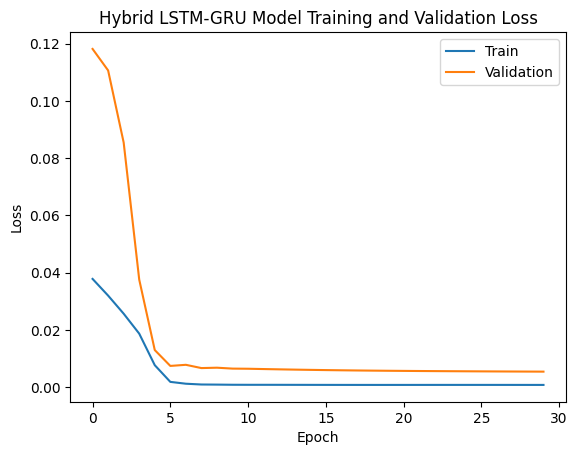

In [15]:
# Define the hybrid GRU-LSTM model
class HybridGRULSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HybridGRULSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out[:, -1, :].unsqueeze(1))  # Taking only the last output of LSTM
        out = self.fc(gru_out[:, -1, :])
        return out

# Data preparation
# Assuming you have already split your data into X_train, y_train, X_Val, y_Val, X_test, y_test

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_val_torch = torch.tensor(X_Val, dtype=torch.float32)
y_val_torch = torch.tensor(y_Val, dtype=torch.float32)

# Model initialization
input_size = 1  # Assuming input is univariate time series
hidden_size = 64
output_size = 1
model = HybridGRULSTM(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training the model
num_epochs = 30
batch_size = 32
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    model.train()
    for i in range(0, len(X_train_torch), batch_size):
        inputs = X_train_torch[i:i+batch_size]
        targets = y_train_torch[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        epoch_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    train_loss = epoch_train_loss / (len(X_train_torch) / batch_size)
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_torch)
        val_loss = criterion(val_outputs, y_val_torch).item()
        val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plotting the loss
plt.plot(range(num_epochs), train_losses, label='Train')
plt.plot(range(num_epochs), val_losses, label='Validation')
plt.title('Hybrid LSTM-GRU Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Hybrid_LSTM_GRU_Model_Loss.png')
plt.show()

In [16]:
# Get predictions for the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_torch)
hybrid_predictions_val = val_outputs.numpy()

# Inverse transform the predictions and ground truth
hybrid_predictions_val_inv = scaler.inverse_transform(hybrid_predictions_val)
y_val_inv = scaler.inverse_transform(y_Val)

# Calculate RMSE
rmse_val = np.sqrt(mean_squared_error(y_val_inv, hybrid_predictions_val_inv))
print("Validation RMSE:", rmse_val)

# Calculate MAPE
mape_val = mean_absolute_percentage_error(y_val_inv, hybrid_predictions_val_inv)
print("Validation MAPE:", mape_val)

# Calculate MSE
mse_val = mean_square_error(y_val_inv, hybrid_predictions_val_inv)
print("Validation MSE:", mse_val)

Validation RMSE: 2.7393272203639616
Validation MAPE: 1.2309057623902264
Validation MSE: 7.503913620226949


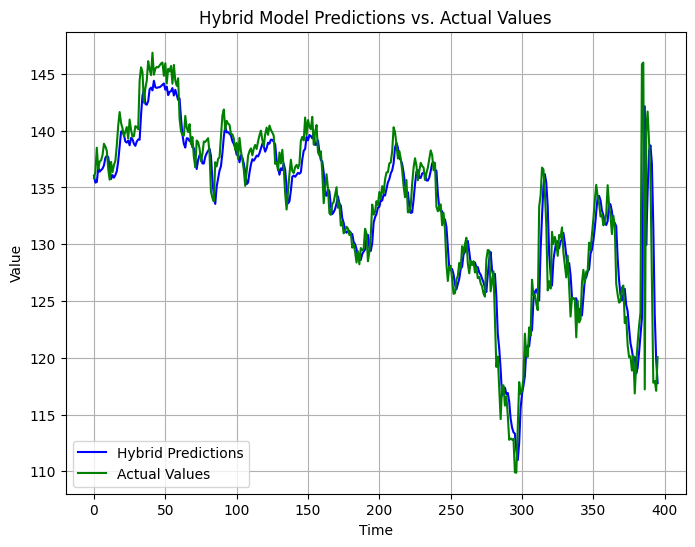

In [17]:
x = range(len(hybrid_predictions_val))

plt.figure(figsize=(8, 6))
plt.plot(x, hybrid_predictions_val_inv, label='Hybrid Predictions', color='blue')
plt.plot(x, y_val_inv, label='Actual Values', color='green')

plt.title('Hybrid Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.savefig('Hybrid_Model_Predictions_vs_Actual_Values.png')
plt.show()

**GRU LSTM Model Testing**

In [18]:
# Get predictions for the testing set
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
hybrid_predictions_test = test_outputs.numpy()

# Inverse transform the predictions and ground truth
hybrid_predictions_test_inv = scaler.inverse_transform(hybrid_predictions_test)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE for testing set
rmse_test = np.sqrt(mean_squared_error(y_test_inv, hybrid_predictions_test_inv))
print("Testing RMSE:", rmse_test)

# Calculate MAPE for testing set
mape_test = mean_absolute_percentage_error(y_test_inv, hybrid_predictions_test_inv)
print("Testing MAPE:", mape_test)

# Calculate MSE for testing set
mse_test = mean_square_error(y_test_inv, hybrid_predictions_test_inv)
print("Testing MSE:", mse_test)

Testing RMSE: 1.2980160885256464
Testing MAPE: 0.7154183302912352
Testing MSE: 1.6848457660714187


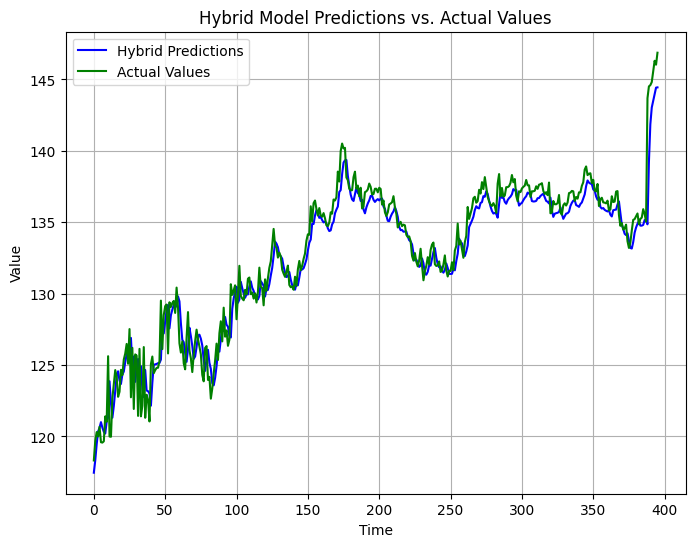

In [19]:
x = range(len(hybrid_predictions_test))

plt.figure(figsize=(8, 6))
plt.plot(x, hybrid_predictions_test_inv, label='Hybrid Predictions', color='blue')
plt.plot(x, y_test_inv, label='Actual Values', color='green')

plt.title('Hybrid Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.savefig('Hybrid_Model_Predictions_vs_Actual_Values.png')
plt.show()

**Hybrid GRU Model Prediction**

In [20]:
hybrid_predictions_test_inv

array([[117.46328 ],
       [118.33489 ],
       [119.46384 ],
       [120.35571 ],
       [120.60891 ],
       [121.00509 ],
       [120.61619 ],
       [120.32967 ],
       [120.20779 ],
       [121.04833 ],
       [121.34987 ],
       [123.86611 ],
       [122.34348 ],
       [121.316345],
       [122.1358  ],
       [123.18751 ],
       [124.26717 ],
       [124.56588 ],
       [123.91582 ],
       [123.6767  ],
       [124.34623 ],
       [124.54663 ],
       [125.1994  ],
       [125.75348 ],
       [126.3681  ],
       [125.93386 ],
       [126.9012  ],
       [124.946785],
       [125.60236 ],
       [123.8278  ],
       [124.81573 ],
       [125.4249  ],
       [123.56772 ],
       [124.92467 ],
       [123.32085 ],
       [122.76314 ],
       [124.65846 ],
       [123.219986],
       [123.17062 ],
       [123.01186 ],
       [122.15588 ],
       [123.77011 ],
       [125.01826 ],
       [125.05021 ],
       [125.081345],
       [125.13557 ],
       [125.147484],
       [125.3

In [22]:
import datetime
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], hybrid_predictions_test_inv[-14:]):
    print(f"{date.date()}: {price}")

2024-05-22: [135.08983]
2024-05-23: [134.76411]
2024-05-24: [134.7644]
2024-05-25: [134.81598]
2024-05-26: [135.15346]
2024-05-27: [135.15668]
2024-05-28: [134.8551]
2024-05-29: [139.20596]
2024-05-30: [141.85648]
2024-05-31: [143.03452]
2024-06-01: [143.50165]
2024-06-02: [143.94923]
2024-06-03: [144.42786]
2024-06-04: [144.4436]


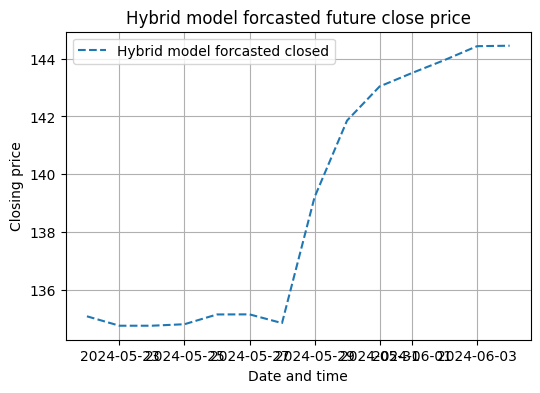

In [23]:
plt.figure(figsize=(6,4))

plt.plot(next_14_days[:14], hybrid_predictions_test_inv[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.show()

**CNN model**

**Model Fitting**

Epoch [1/20], Train Loss: 0.0159
Epoch [2/20], Train Loss: 0.0094
Epoch [3/20], Train Loss: 0.0056
Epoch [4/20], Train Loss: 0.0056
Epoch [5/20], Train Loss: 0.0051
Epoch [6/20], Train Loss: 0.0045
Epoch [7/20], Train Loss: 0.0037
Epoch [8/20], Train Loss: 0.0045
Epoch [9/20], Train Loss: 0.0035
Epoch [10/20], Train Loss: 0.0034
Epoch [11/20], Train Loss: 0.0034
Epoch [12/20], Train Loss: 0.0032
Epoch [13/20], Train Loss: 0.0031
Epoch [14/20], Train Loss: 0.0031
Epoch [15/20], Train Loss: 0.0030
Epoch [16/20], Train Loss: 0.0030
Epoch [17/20], Train Loss: 0.0030
Epoch [18/20], Train Loss: 0.0030
Epoch [19/20], Train Loss: 0.0029
Epoch [20/20], Train Loss: 0.0029


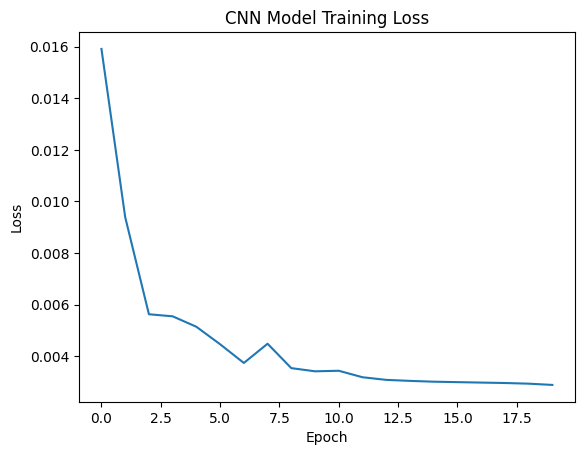

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * ((step_index - 2) // 2), 64)  # Adjust the input size based on your step_index
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

# Reshape the input data to match the CNN input shape [batch_size, in_channels, sequence_length]
X_train_torch = X_train_torch.permute(0, 2, 1)  # Rearrange dimensions to match Conv1d expectation

# Training loop
num_epochs = 20
batch_size = 16
train_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    for i in range(0, len(X_train_torch), batch_size):
        inputs = X_train_torch[i:i+batch_size]
        targets = y_train_torch[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets.unsqueeze(1))  # Ensure targets have the same shape as outputs
        epoch_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    train_loss = epoch_train_loss / (len(X_train_torch) / batch_size)
    train_losses.append(train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

# Plotting the loss
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses)
plt.title('CNN Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## CNN Model performance in validation set

In [25]:
# Convert validation data to PyTorch tensors
X_val_torch = torch.tensor(X_Val, dtype=torch.float32)
y_val_torch = torch.tensor(y_Val, dtype=torch.float32)

# Reshape the input data to match the CNN input shape [batch_size, in_channels, sequence_length]
X_val_torch = X_val_torch.permute(0, 2, 1)  # Rearrange dimensions to match Conv1d expectation

# Get predictions for the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_torch)
cnn_predictions_val = val_outputs.numpy()

# Calculate RMSE, MSE, and MAPE for validation set
cnn_predictions_val_inv = scaler.inverse_transform(cnn_predictions_val.reshape(-1, 1)).flatten()
y_val_inv = scaler.inverse_transform(y_Val)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Calculate RMSE for validation set
rmse_val = np.sqrt(mean_squared_error(y_val_inv, cnn_predictions_val_inv))
print("Validation RMSE:", rmse_val)

# Calculate MAPE for validation set
mape_val = mean_absolute_percentage_error(y_val_inv, cnn_predictions_val_inv)
print("Validation MAPE:", mape_val)

# Calculate MSE for validation set
mse_val = mean_squared_error(y_val_inv, cnn_predictions_val_inv)
print("Validation MSE:", mse_val)

Validation RMSE: 5.154136297822125
Validation MAPE: 0.031847065766434444
Validation MSE: 26.565120976527552


## CNN MODEL PERFORMANCE USING TEST SET

In [26]:
# Convert test data to PyTorch tensors
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Reshape the input data to match the CNN input shape [batch_size, in_channels, sequence_length]
X_test_torch = X_test_torch.permute(0, 2, 1)  # Rearrange dimensions to match Conv1d expectation

# Get predictions for the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
cnn_predictions_test = test_outputs.numpy()

# Calculate RMSE, MSE, and MAPE for test set
cnn_predictions_test_inv = scaler.inverse_transform(cnn_predictions_test.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y_test_inv, cnn_predictions_test_inv))
print("Test RMSE:", rmse_test)

# Calculate MAPE for test set
mape_test = mean_absolute_percentage_error(y_test_inv, cnn_predictions_test_inv)
print("Test MAPE:", mape_test)

# Calculate MSE for test set
mse_test = mean_squared_error(y_test_inv, cnn_predictions_test_inv)
print("Test MSE:", mse_test)


Test RMSE: 3.394677014405715
Test MAPE: 0.02170027317620416
Test MSE: 11.5238320321345


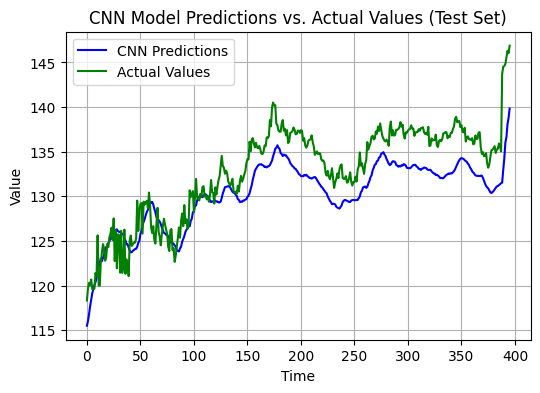

In [27]:
# Plotting the predictions vs. actual values for the test set
x = range(len(cnn_predictions_test_inv))

plt.figure(figsize=(6, 4))
plt.plot(x, cnn_predictions_test_inv, label='CNN Predictions', color='blue')
plt.plot(x, y_test_inv, label='Actual Values', color='green')

plt.title('CNN Model Predictions vs. Actual Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
cnn_predictions_test_inv

array([115.49546 , 116.019455, 116.80879 , 117.6863  , 118.39741 ,
       119.14018 , 119.57747 , 120.06499 , 120.36818 , 120.80999 ,
       121.19592 , 122.1753  , 122.55256 , 123.04489 , 122.7191  ,
       123.09915 , 123.383606, 124.06403 , 124.29645 , 124.521706,
       124.73874 , 124.95786 , 125.29663 , 125.45425 , 125.80784 ,
       125.858376, 126.27326 , 126.18467 , 126.30324 , 126.08634 ,
       126.022316, 126.01695 , 125.83786 , 125.80962 , 125.68837 ,
       125.23013 , 125.063774, 124.623604, 124.60393 , 124.25023 ,
       123.925476, 123.71286 , 123.7401  , 123.907555, 123.97957 ,
       124.10255 , 124.10914 , 124.349396, 124.78876 , 125.00879 ,
       125.77208 , 126.11843 , 126.792656, 127.11394 , 127.457184,
       127.89508 , 128.26065 , 128.47653 , 128.7453  , 129.11008 ,
       129.33824 , 129.36931 , 129.0724  , 128.5981  , 128.20514 ,
       127.65104 , 127.29837 , 127.33909 , 127.1628  , 126.91883 ,
       126.49488 , 126.16517 , 125.898605, 125.8396  , 125.688

In [29]:
import datetime
num_future_days = 14
lastest_date = pd.to_datetime(data['Date'].iat[-1])
# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]
# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], cnn_predictions_test_inv[-14:]):
    print(f"{date.date()}: {price}")

2024-05-22: 130.92945861816406
2024-05-23: 131.11476135253906
2024-05-24: 131.14706420898438
2024-05-25: 131.26292419433594
2024-05-26: 131.3465118408203
2024-05-27: 131.46995544433594
2024-05-28: 131.52407836914062
2024-05-29: 132.94937133789062
2024-05-30: 134.2119140625
2024-05-31: 136.00889587402344
2024-06-01: 136.62649536132812
2024-06-02: 138.06607055664062
2024-06-03: 138.77723693847656
2024-06-04: 139.8316650390625


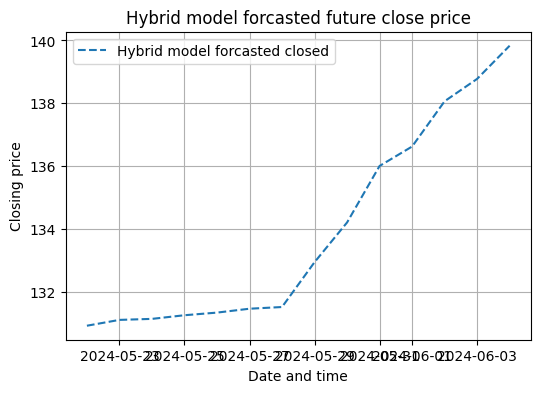

In [30]:
plt.figure(figsize=(6,4))

plt.plot(next_14_days[:14], cnn_predictions_test_inv[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.savefig('GBPBDT forecasting')
plt.show()

## Sentimental Analysis for GBP to Bangladeshi Taka

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Existing DataFrame
data = {
    'Open': [117.79, 118.42, 119.11, 117.54, 117.51, 136.50, 136.54, 136.51],
    'High': [118.64, 119.00, 119.21, 117.95, 118.37, 136.50, 136.54, 136.51],
    'Low': [117.63, 118.36, 118.43, 117.30, 117.38, 136.37, 136.39, 136.51],
    'Close': [118.29, 118.83, 118.50, 117.64, 118.06, 136.39, 136.37, 136.32],
    'Adj Close': [118.29, 118.83, 118.50, 117.64, 118.06, 136.39, 136.37, 136.32],
    'Volume': [0, 0, 0, 0, 0, 0, 0, 0],
    'Date': pd.to_datetime(['2005-08-11', '2005-08-12', '2005-08-15', '2005-08-16', '2005-08-17', '2024-03-28', '2024-03-29', '2024-04-01'])
}
financial_df = pd.DataFrame(data)
financial_df.set_index('Date', inplace=True)

# Simulated sentiment data
sentiment_data = {
    'Date': pd.to_datetime(['2005-08-11', '2005-08-12', '2005-08-15', '2005-08-16', '2005-08-17', '2024-03-28', '2024-03-29', '2024-04-01']),
    'Sentiment': np.random.uniform(-1, 1, size=8)
}
sentiment_df = pd.DataFrame(sentiment_data)
sentiment_df.set_index('Date', inplace=True)


In [32]:
# Merge the financial data with the sentiment data
merged_df = financial_df.merge(sentiment_df, left_index=True, right_index=True, how='left')
print(merged_df)


              Open    High     Low   Close  Adj Close  Volume  Sentiment
Date                                                                    
2005-08-11  117.79  118.64  117.63  118.29     118.29       0  -0.557062
2005-08-12  118.42  119.00  118.36  118.83     118.83       0  -0.248849
2005-08-15  119.11  119.21  118.43  118.50     118.50       0  -0.325465
2005-08-16  117.54  117.95  117.30  117.64     117.64       0  -0.805014
2005-08-17  117.51  118.37  117.38  118.06     118.06       0  -0.169530
2024-03-28  136.50  136.50  136.37  136.39     136.39       0   0.940397
2024-03-29  136.54  136.54  136.39  136.37     136.37       0   0.069733
2024-04-01  136.51  136.51  136.51  136.32     136.32       0   0.385982


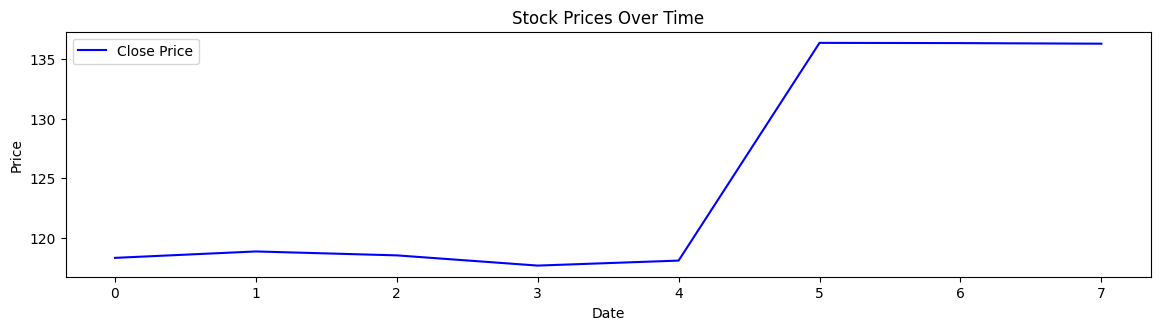

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(merged_df)
df.reset_index('Date', inplace=True)
# Time Series Plot for Stock Prices and Sentiment
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

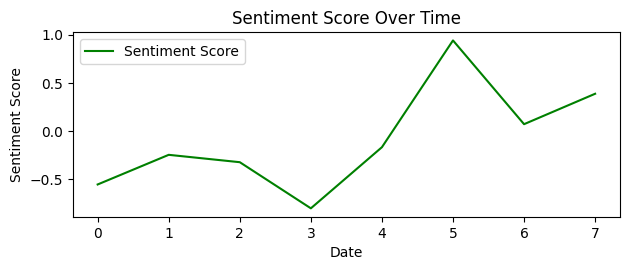

Mean Squared Error: 0.0330612401551101


In [34]:
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Sentiment'], label='Sentiment Score', color='green')
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()

plt.tight_layout()
plt.show()

# Prepare the data for modeling
X = df[['Open', 'High', 'Low', 'Volume', 'Sentiment']]
y = df['Close']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

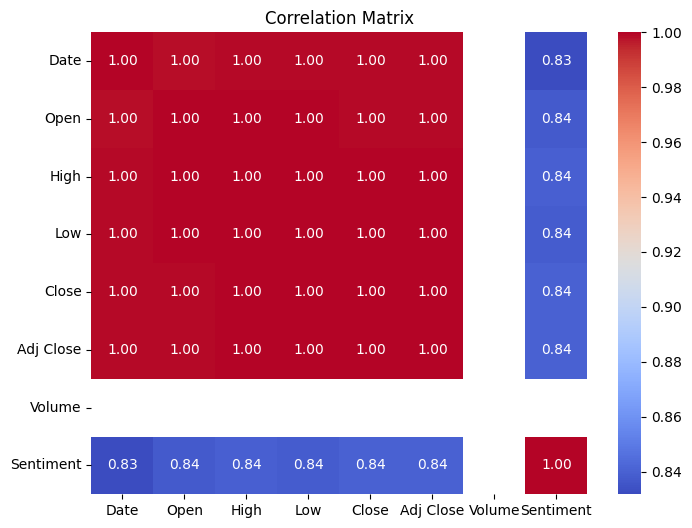

In [35]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()